Here, we'll test how dynamically novel the components of the CST- and RTT-unique spaces are.

First, load the data and split the subspaces out:

In [1]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

Let's double-check that the split worked satisfactorily with a variance plot.

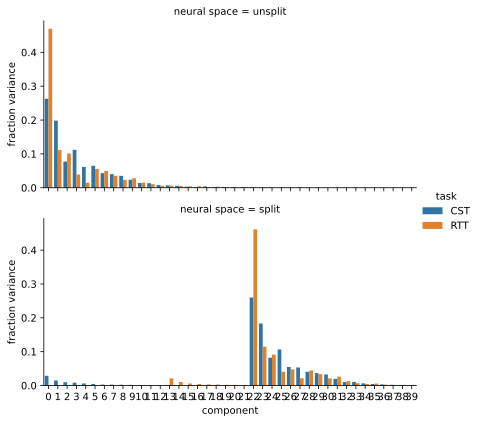

In [2]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series(index=pd.MultiIndex.from_product(


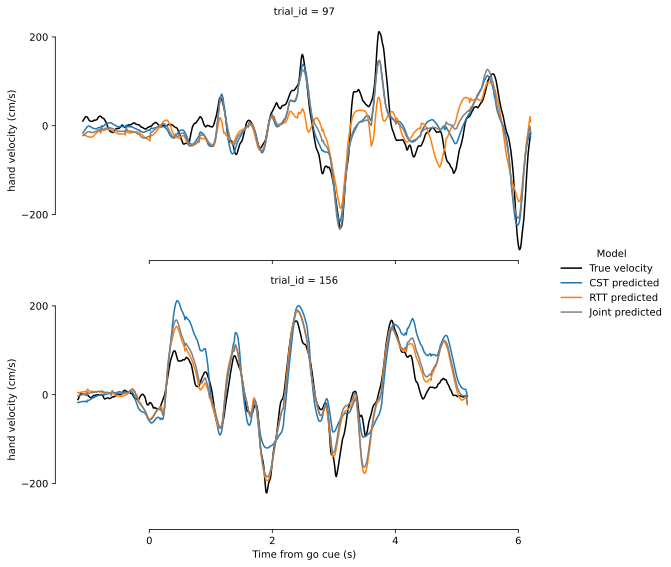

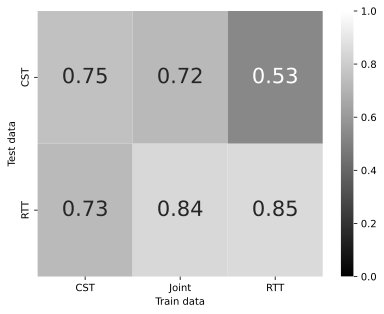

In [11]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0,
)


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series(index=pd.MultiIndex.from_product(


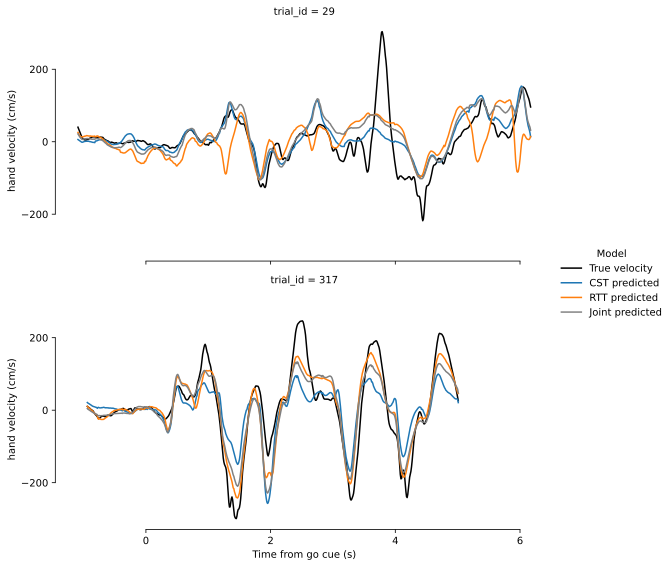

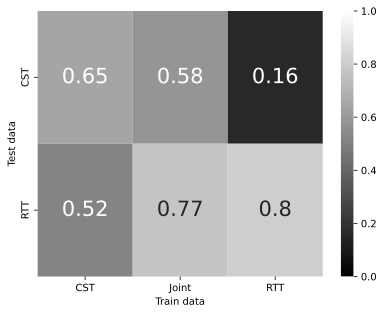

In [13]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_shared',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0,
)


In [46]:
src.crystal.extract_trial_event_times(td).loc['Prez','2022-07-21',2]

event
ctHold          0.0
pretaskHold    0.42
goCue          0.98
rtgoCue        0.98
rtHold         1.68
rtgoCue        1.69
rtHold         2.57
rtgoCue        2.58
rtHold         3.07
rtgoCue        3.08
rtHold         3.75
rtgoCue        3.76
rtHold          3.8
rtgoCue        3.81
rtHold         4.37
rtgoCue        4.38
rtHold         4.93
rtgoCue        4.94
rtHold         5.02
reward         5.03
end            5.24
dtype: object